# AI-Powered Heart Disease Prediction System

In [1]:
!pip install shap
!pip install lime

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import shap
import lime
import lime.lime_tabular


# Load the Dataset

In [61]:
# Load the dataset
data_path = 'HeartDisease.csv'
data = pd.read_csv(data_path)

# Display the first few rows to understand the structure of the dataset
print("Dataset Preview:")
print(data.head())


Dataset Preview:
   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                   

# Data Cleaning and Preprocessing

In [62]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())



Missing Values:
age                              0
sex                              0
chest_pain_type                  0
resting_blood_pressure           0
cholestoral                      0
fasting_blood_sugar              0
rest_ecg                         0
Max_heart_rate                   0
exercise_induced_angina          0
oldpeak                          0
slope                            0
vessels_colored_by_flourosopy    0
thalassemia                      0
target                           0
dtype: int64


In [63]:
X = data.drop('target', axis=1)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

### Pipeline for Numerical Data Preprocessing

In [64]:
# Imputers for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

### Pipeline for Categorical Data Preprocessing

In [65]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop=None))
])


In [66]:
# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Splitting the Data

In [67]:
# Splitting the Data
X = data.drop('target', axis=1)
y = data['target']


In [68]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preprocessing the Data

In [69]:
# Fit and transform the training data, transform the test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [70]:
# Save the preprocessed data
print("\nPreprocessing Complete:")
print("Training data shape:", X_train_preprocessed.shape)
print("Testing data shape:", X_test_preprocessed.shape)


Preprocessing Complete:
Training data shape: (820, 30)
Testing data shape: (205, 30)


# Exploratory Data Analysis (EDA) and Visualizations

## Basic Statistics and Distributions

In [71]:
# Basic Statistics and Distributions
print("\nBasic Statistics:")
print(data.describe())


Basic Statistics:
               age  resting_blood_pressure  cholestoral  Max_heart_rate  \
count  1025.000000             1025.000000   1025.00000     1025.000000   
mean     54.434146              131.611707    246.00000      149.114146   
std       9.072290               17.516718     51.59251       23.005724   
min      29.000000               94.000000    126.00000       71.000000   
25%      48.000000              120.000000    211.00000      132.000000   
50%      56.000000              130.000000    240.00000      152.000000   
75%      61.000000              140.000000    275.00000      166.000000   
max      77.000000              200.000000    564.00000      202.000000   

           oldpeak       target  
count  1025.000000  1025.000000  
mean      1.071512     0.513171  
std       1.175053     0.500070  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.800000     1.000000  
75%       1.800000     1.000000  
max       6.200000     1.000000  

## Visualizing the distribution of numerical features

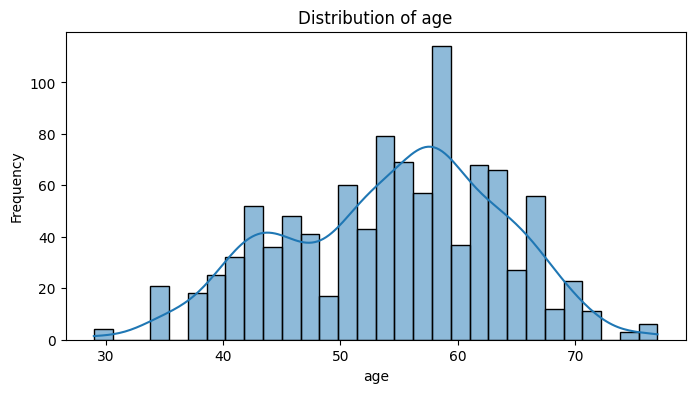

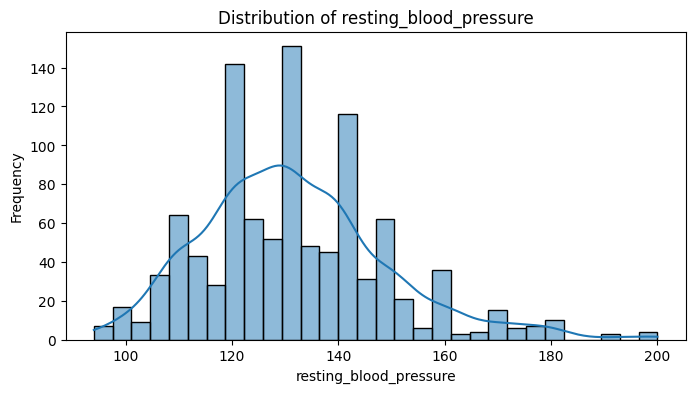

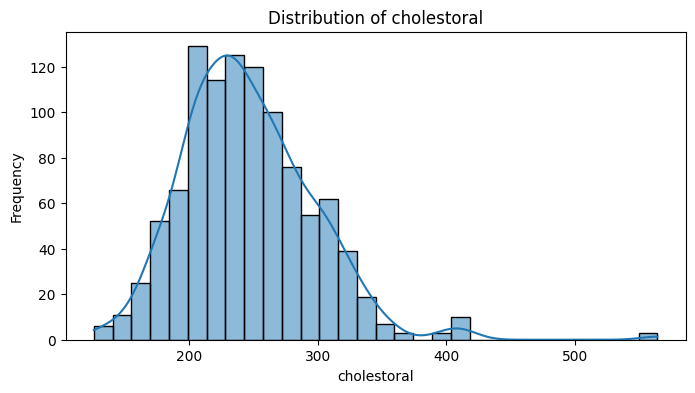

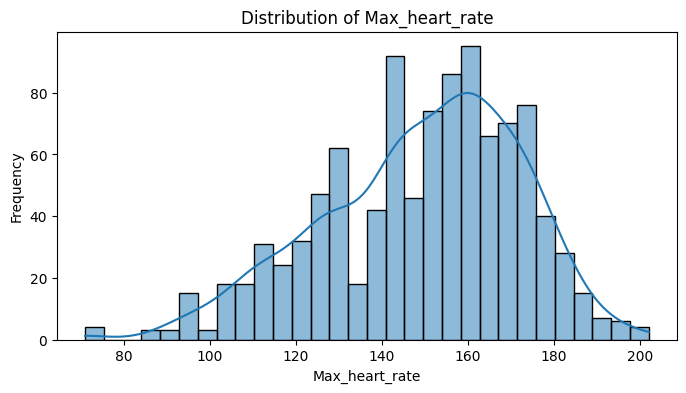

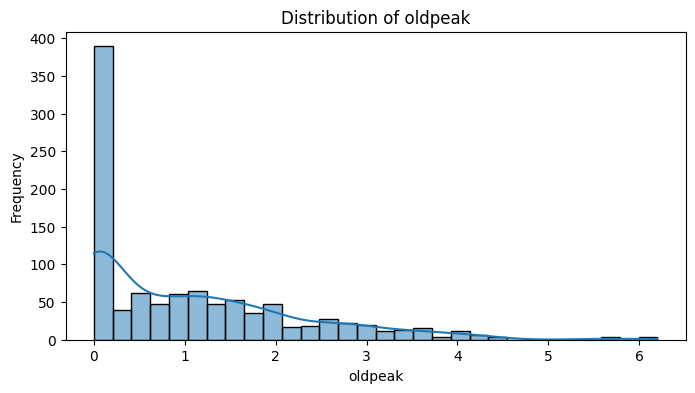

In [72]:
for column in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

## Correlation Heatmap

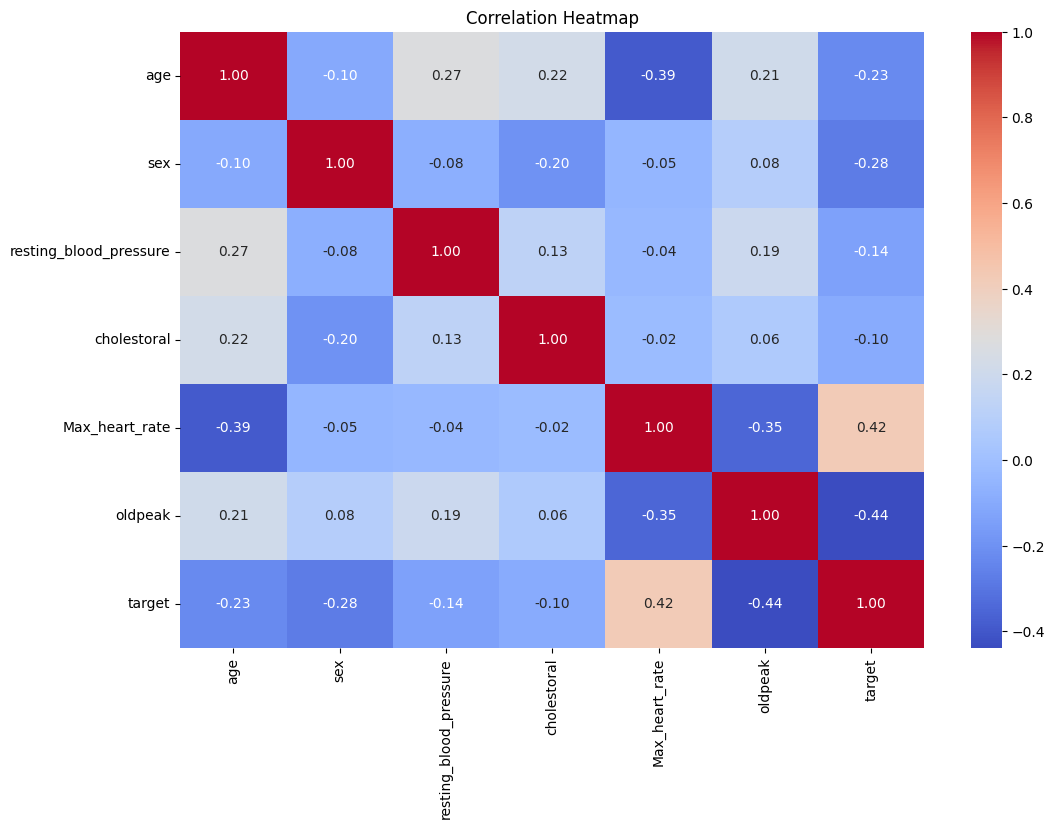

In [73]:
# Ensure 'sex' is explicitly converted to numeric
data['sex'] = data['sex'].map({'Male': 1, 'Female': 0})  # Convert categorical values to numerical

# Now, recalculate correlation
numeric_data = data.select_dtypes(include=['number'])  # Ensure numeric columns only
correlation_matrix = numeric_data.corr()

# Plot heatmap again
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


### Pie Chart - Proportion of Heart Disease in Dataset

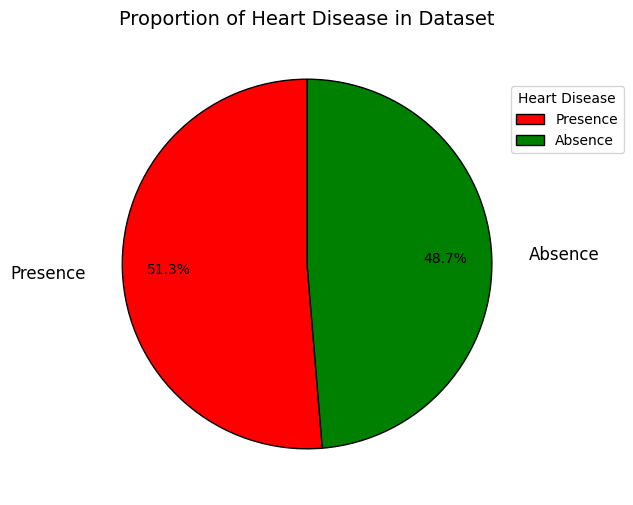

In [74]:
# Create a pie chart
# Define colors and labels
colors = ['red', 'green']
labels = ["Presence", "Absence"]

# Create figure
plt.figure(figsize=(7, 6))

# Plot pie chart with better label positioning
wedges, texts, autotexts = plt.pie(
    data['target'].value_counts(), 
    autopct='%1.1f%%', 
    colors=colors, 
    startangle=90, 
    wedgeprops={'edgecolor': 'black'}, 
    pctdistance=0.75,  # Moves percentage labels inward to prevent overlap
    labels=labels, 
    labeldistance=1.2  # Moves slice labels further out
)

# Adjust label font sizes
for text in texts:
    text.set_fontsize(12)  # Label size
for autotext in autotexts:
    autotext.set_fontsize(10)  # Percentage size

# Add title
plt.title("Proportion of Heart Disease in Dataset", fontsize=14)

# Move legend outside the pie chart
plt.legend(labels, title="Heart Disease", bbox_to_anchor=(1.2, 0.9), loc="upper right")

# Show the plot
plt.show()


# Data Distribution across different Categories

C:\Users\Hammad\AppData\Local\Temp\ipykernel_10828\2599279073.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sex', data=data, palette='viridis', ax=axes[0])
C:\Users\Hammad\AppData\Local\Temp\ipykernel_10828\2599279073.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Female', 'Male'])
C:\Users\Hammad\AppData\Local\Temp\ipykernel_10828\2599279073.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='chest_pain_type', data=data, palette='viridis', ax=axes[1])
C:\Users\Hammad\AppData\Local\Temp\ipykernel_10828\2599279073.py:22: FutureWarning: 

Passing `palette` with

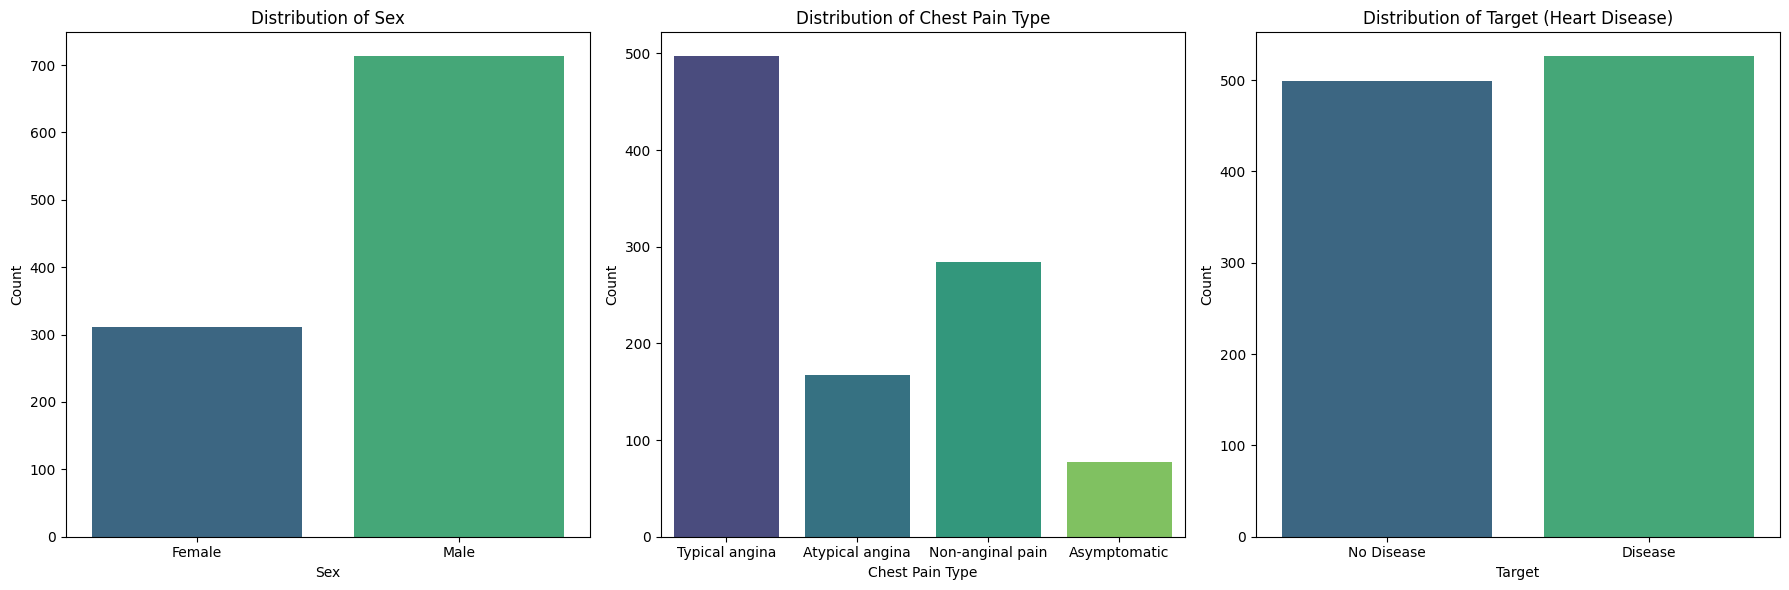

In [75]:
# ------------------------------
# 1. Distribution across different Categories
# ------------------------------

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar chart for 'sex'
sns.countplot(x='sex', data=data, palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of Sex')
axes[0].set_xticklabels(['Female', 'Male'])
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')

# Bar chart for 'chest_pain_type'
sns.countplot(x='chest_pain_type', data=data, palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of Chest Pain Type')
axes[1].set_xlabel('Chest Pain Type')
axes[1].set_ylabel('Count')

# Bar chart for 'target'
sns.countplot(x='target', data=data, palette='viridis', ax=axes[2])
axes[2].set_title('Distribution of Target (Heart Disease)')
axes[2].set_xticklabels(['No Disease', 'Disease'])
axes[2].set_xlabel('Target')
axes[2].set_ylabel('Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Relationships Between Features and Target

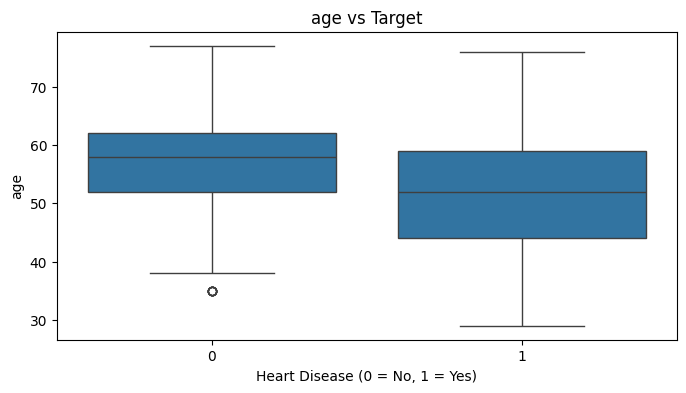

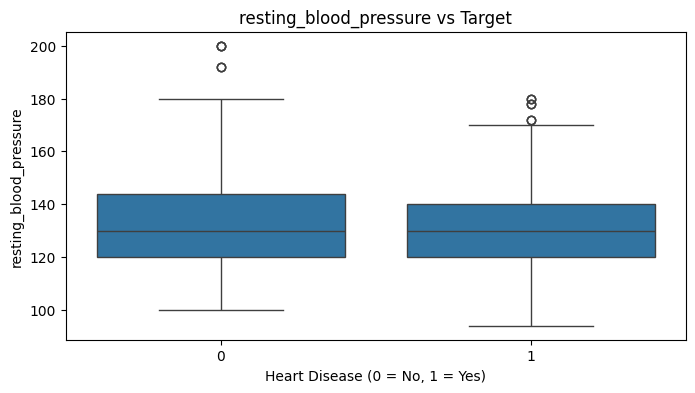

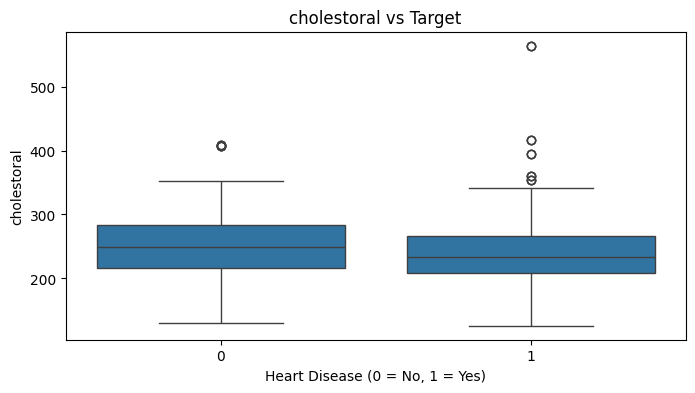

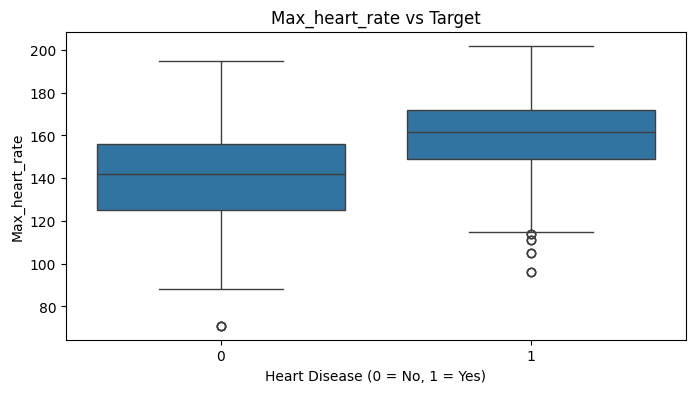

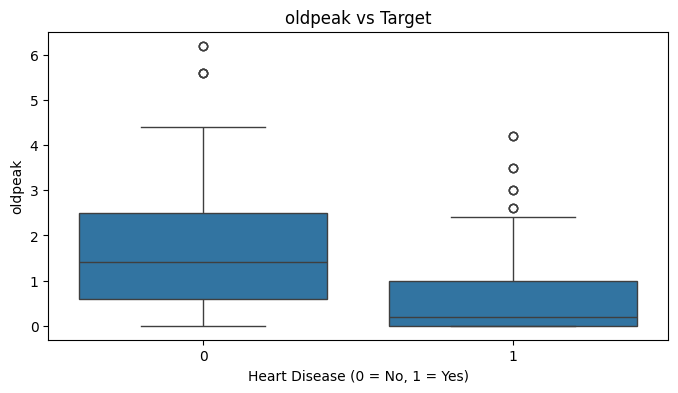

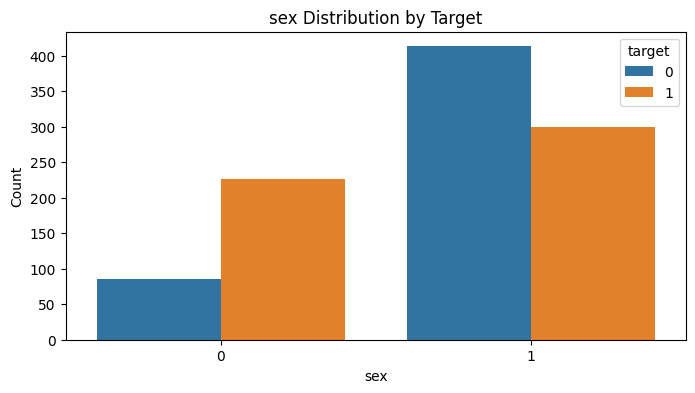

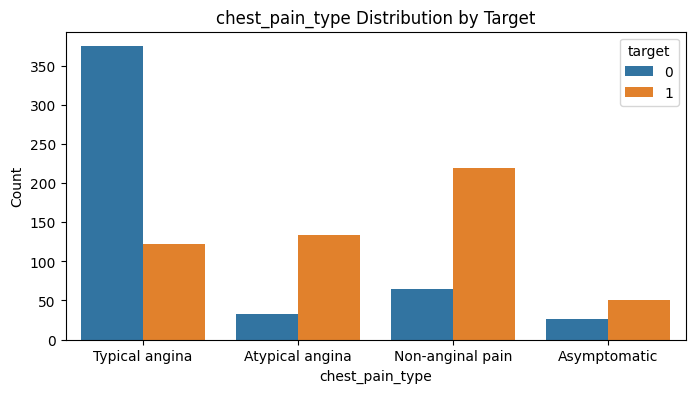

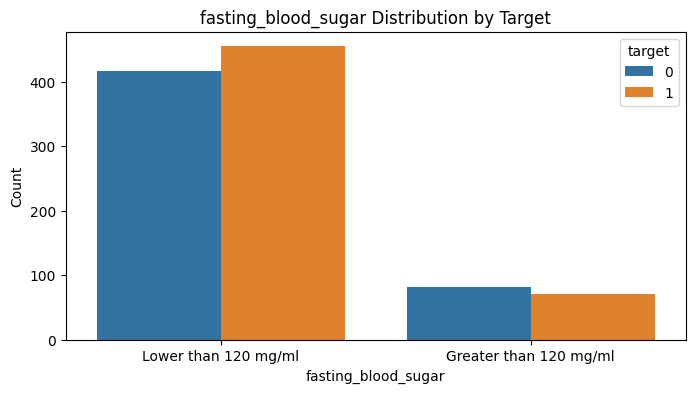

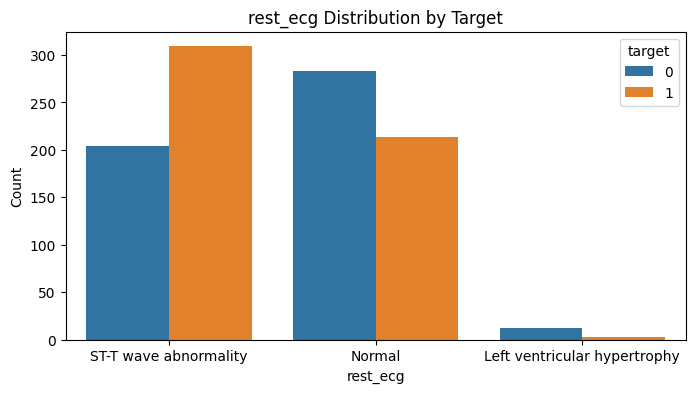

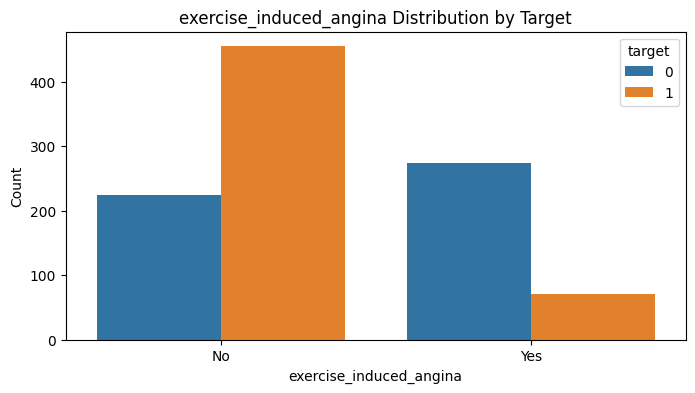

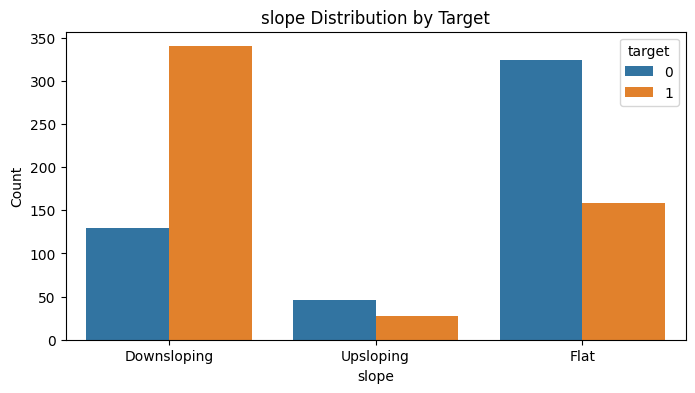

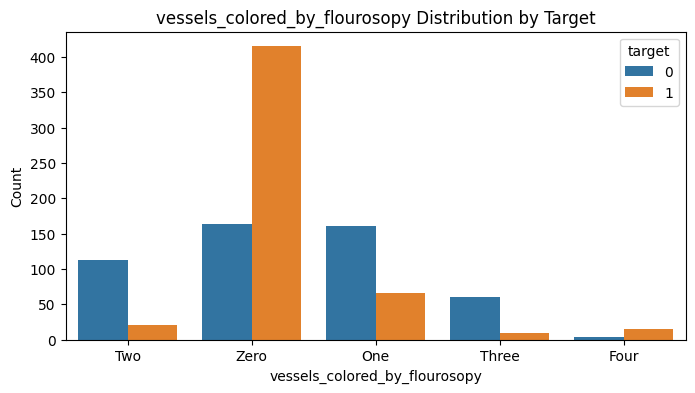

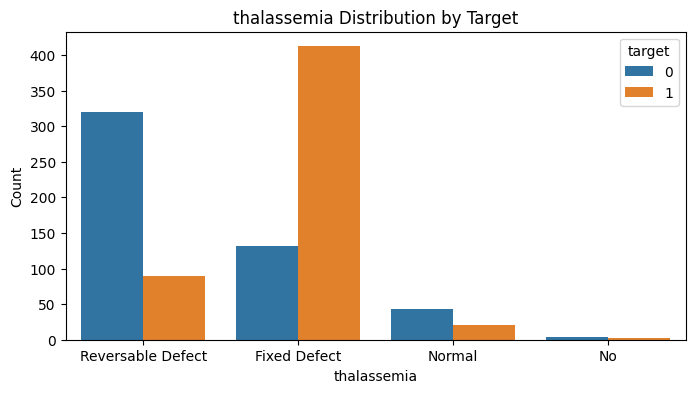

In [76]:
# ------------------------------
# 2. Relationships Between Features and Target
# ------------------------------

# Boxplot for numerical features vs target
for column in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='target', y=column, data=data)
    plt.title(f'{column} vs Target')
    plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
    plt.ylabel(column)
    plt.show()

# Countplot for categorical features vs target
for column in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=column, hue='target', data=data)
    plt.title(f'{column} Distribution by Target')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()


## Outlier Detection using IQR

In [77]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Select numerical columns for outlier detection
numerical_cols = numerical_features

# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Find outliers for each numerical column
for col in numerical_cols:
    outliers = detect_outliers_iqr(data, col)
    print(f"Outliers in {col}: {outliers.shape[0]} rows")


Outliers in age: 0 rows
Outliers in resting_blood_pressure: 30 rows
Outliers in cholestoral: 16 rows
Outliers in Max_heart_rate: 4 rows
Outliers in oldpeak: 7 rows


## Outlier Detection Using Z-Score

In [78]:
from scipy import stats

# Detect outliers using Z-score (Threshold = ±3)
z_scores = stats.zscore(data[numerical_cols])
outliers = (abs(z_scores) > 3).sum(axis=0)  # Count outliers per column

# Display results
print("Number of outliers detected per column using Z-score:")
print(outliers)


Number of outliers detected per column using Z-score:
age                        0
resting_blood_pressure     7
cholestoral               13
Max_heart_rate             4
oldpeak                    7
dtype: int64


## Boxplots for Outlier Detection

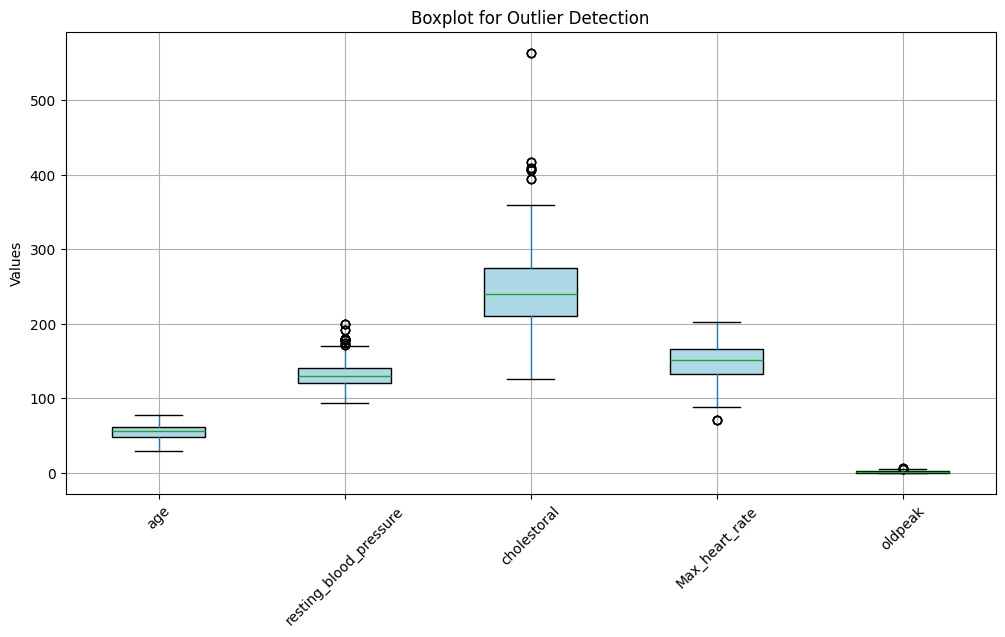

In [79]:
# ------------------------------
# Create Boxplots for Outlier Detection
# ------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Create boxplots for all numerical features
plt.figure(figsize=(12, 6))
data[numerical_cols].boxplot(rot=45, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Boxplot for Outlier Detection")
plt.ylabel("Values")
plt.show()


## Removing Outliers using IQR and Visualization

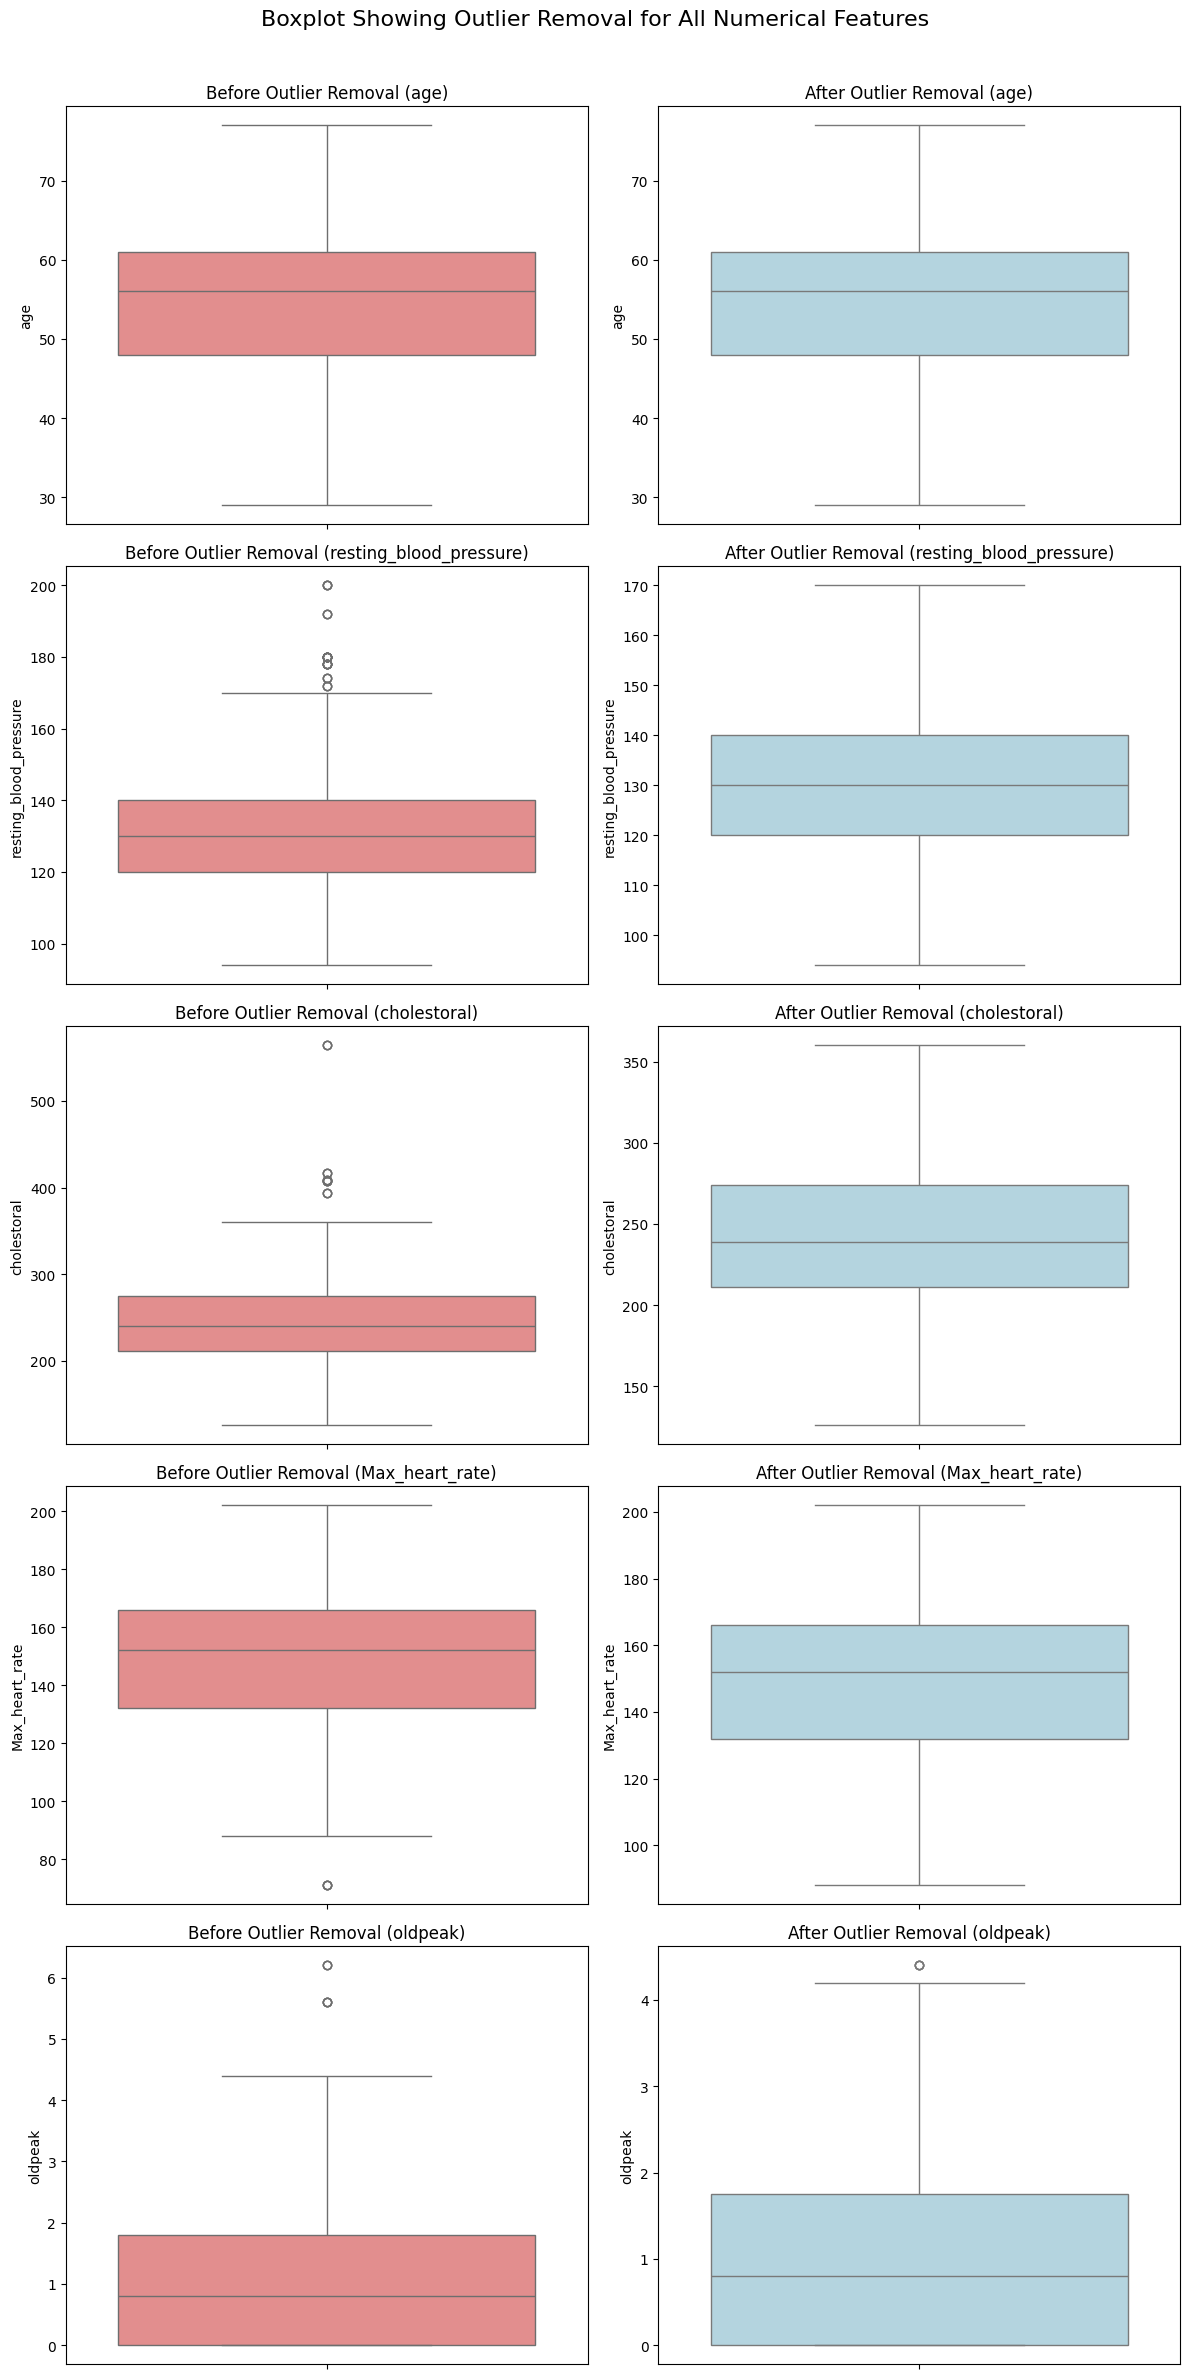

In [80]:
# ------------------------------
# Removing Outliers using IQR Method
# ------------------------------

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Create subplots for before and after outlier removal
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=2, figsize=(12, 5 * len(numerical_features)))

# Loop through numerical features to plot boxplots before and after outlier removal
for i, feature in enumerate(numerical_features):
    # Remove outliers
    data_cleaned = remove_outliers_iqr(data, feature)

    # Boxplot before outlier removal
    sns.boxplot(y=data[feature], ax=axes[i, 0], color="lightcoral")
    axes[i, 0].set_title(f"Before Outlier Removal ({feature})")

    # Boxplot after outlier removal
    sns.boxplot(y=data_cleaned[feature], ax=axes[i, 1], color="lightblue")
    axes[i, 1].set_title(f"After Outlier Removal ({feature})")

# Adjust layout and add title
plt.suptitle("Boxplot Showing Outlier Removal for All Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Show the plot
plt.show()


# Model Development, Evaluation, and Comparison

## Training Baseline Models

In [81]:
# ------------------------------
# 1. Baseline Models: Logistic Regression and Decision Tree
# ------------------------------

log_reg = LogisticRegression(random_state=42)
dec_tree = DecisionTreeClassifier(random_state=42)

# Train baseline models
log_reg.fit(X_train_preprocessed, y_train)
dec_tree.fit(X_train_preprocessed, y_train)

# Predictions
log_reg_preds = log_reg.predict(X_test_preprocessed)
dec_tree_preds = dec_tree.predict(X_test_preprocessed)


## Evaluate Baseline Models

In [82]:
# ------------------------------
# 2. Evaluate Baseline Models
# ------------------------------

print("\nLogistic Regression Performance:")
print(classification_report(y_test, log_reg_preds))

print("\nDecision Tree Performance:")
print(classification_report(y_test, dec_tree_preds))



Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       102
           1       0.78      0.89      0.83       103

    accuracy                           0.82       205
   macro avg       0.83      0.82      0.82       205
weighted avg       0.83      0.82      0.82       205


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



## Cross-Validation for Baseline Models

In [83]:
# ------------------------------
# 3. Cross-validation for Baseline Models
# ------------------------------

from sklearn.model_selection import cross_val_score
import numpy as np

# Cross-validation for Baseline Models
models = [log_reg, dec_tree]
model_names = ['Logistic Regression', 'Decision Tree']

for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
    print(f"\n{name} Cross-Validation Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")



Logistic Regression Cross-Validation Scores: [0.85365854 0.86585366 0.89634146 0.92073171 0.81707317]
Mean Accuracy: 0.8707 (+/- 0.0356)

Decision Tree Cross-Validation Scores: [0.99390244 0.97560976 0.98780488 0.99390244 0.94512195]
Mean Accuracy: 0.9793 (+/- 0.0183)


## Training Advanced Models

In [84]:
# ------------------------------
# 4. Advanced Models: Random Forest and Gradient Boosting
# ------------------------------

rf_clf = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

# Train advanced models
rf_clf.fit(X_train_preprocessed, y_train)
gb_clf.fit(X_train_preprocessed, y_train)

# Predictions for advanced models
rf_preds = rf_clf.predict(X_test_preprocessed)
gb_preds = gb_clf.predict(X_test_preprocessed)


## Evaluate Advanced Models

In [85]:
# ------------------------------
# 5. Evaluate Advanced Models
# ------------------------------

print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_preds))

print("\nGradient Boosting Performance:")
print(classification_report(y_test, gb_preds))



Random Forest Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205


Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       102
           1       0.93      0.95      0.94       103

    accuracy                           0.94       205
   macro avg       0.94      0.94      0.94       205
weighted avg       0.94      0.94      0.94       205



## Cross-Validation for Advanced Models

In [86]:
# ------------------------------
# 6. Cross-validation for Advanced Models
# ------------------------------

# Cross-validation for Advanced Models
models = [rf_clf, gb_clf]
model_names = ['Random Forest', 'Gradient Boosting']

for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
    print(f"\n{name} Cross-Validation Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")



Random Forest Cross-Validation Scores: [1.         0.9695122  0.98780488 0.98780488 0.9695122 ]
Mean Accuracy: 0.9829 (+/- 0.0118)

Gradient Boosting Cross-Validation Scores: [0.98780488 0.92073171 0.98170732 0.96341463 0.92682927]
Mean Accuracy: 0.9561 (+/- 0.0276)


## Neural Network Model

In [87]:
# ------------------------------
# 7. Neural Network Model
# ------------------------------

nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_preprocessed.shape[1], activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_preprocessed, y_train, epochs=50, batch_size=16, validation_data=(X_test_preprocessed, y_test), verbose=1)


c:\Users\Hammad\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5232 - loss: 0.7005 - val_accuracy: 0.7610 - val_loss: 0.5549
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7791 - loss: 0.5032 - val_accuracy: 0.7902 - val_loss: 0.4507
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8413 - loss: 0.3609 - val_accuracy: 0.8244 - val_loss: 0.4150
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8474 - loss: 0.3820 - val_accuracy: 0.8341 - val_loss: 0.3968
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8883 - loss: 0.3041 - val_accuracy: 0.8341 - val_loss: 0.3796
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8721 - loss: 0.3036 - val_accuracy: 0.8341 - val_loss: 0.3716
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9095 - loss: 0.2659 - val_accuracy: 0.8341 - val_loss: 0.3546
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8914 - loss: 0.2640 - val_accuracy: 0.8585 - val_lo

## Evaluate the Neural Network

In [88]:
# ------------------------------
# 8. Evaluate Neural Network
# ------------------------------

nn_loss, nn_accuracy = nn_model.evaluate(X_test_preprocessed, y_test, verbose=0)
print("\nNeural Network Performance:")
print(f"Accuracy: {nn_accuracy:.2f}")



Neural Network Performance:
Accuracy: 0.97


## Compare Model Performance

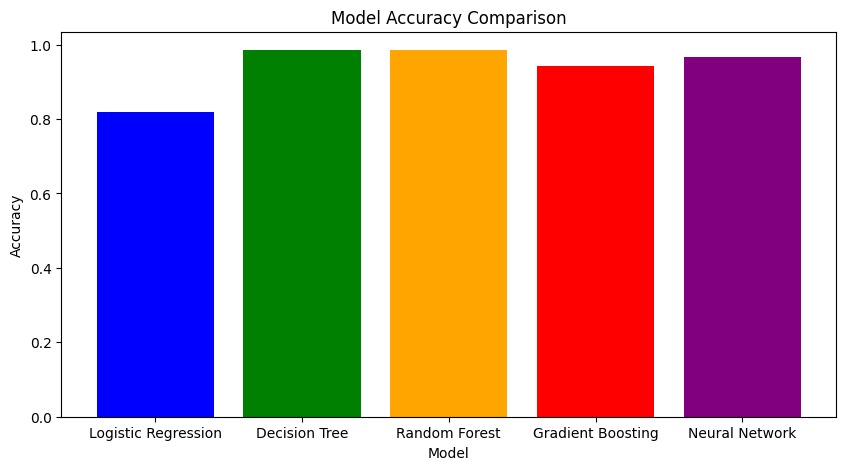

In [89]:
# ------------------------------
# 9. Compare Model Accuracy
# ------------------------------

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network']
accuracy = [
    accuracy_score(y_test, log_reg_preds),
    accuracy_score(y_test, dec_tree_preds),
    accuracy_score(y_test, rf_preds),
    accuracy_score(y_test, gb_preds),
    nn_accuracy
]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracy, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()


# Explainable AI (XAI) - SHAP and LIME

In [90]:
# ------------------------------
# 1. SHAP (SHapley Additive exPlanations) Initialization
# ------------------------------

import shap
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

# Initialize SHAP JavaScript Library
shap.initjs()

# Ensure Preprocessor is Fitted
preprocessor.fit(X_train)  # Fit if not already done

# Get Transformed Feature Names
feature_names_transformed = preprocessor.get_feature_names_out()

# Convert X_test_preprocessed to Pandas DataFrame for easier indexing
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names_transformed)


C:\Users\Hammad\AppData\Local\Temp\ipykernel_10828\2827633725.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [91]:
# ------------------------------
# 2. SHAP Explainer for Tree Models (Random Forest)
# ------------------------------

# Create SHAP Explainer for Tree Models (Random Forest)
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test_preprocessed)

# Ensure Feature Count Matches
if isinstance(shap_values, list):  # For classification models
    shap_values_for_class_1 = np.array(shap_values[1])  # Use class 1 SHAP values
else:
    shap_values_for_class_1 = np.array(shap_values)

# Fix SHAP values if they have an extra dimension
if len(shap_values_for_class_1.shape) == 3:
    shap_values_for_class_1 = shap_values_for_class_1[:, :, 1]  # Select correct class dimension

# Check and fix feature name mismatch
if shap_values_for_class_1.shape[1] != len(feature_names_transformed):
    print("Mismatch Detected: Adjusting feature names!")
    feature_names_transformed = list(feature_names_transformed)[:shap_values_for_class_1.shape[1]]


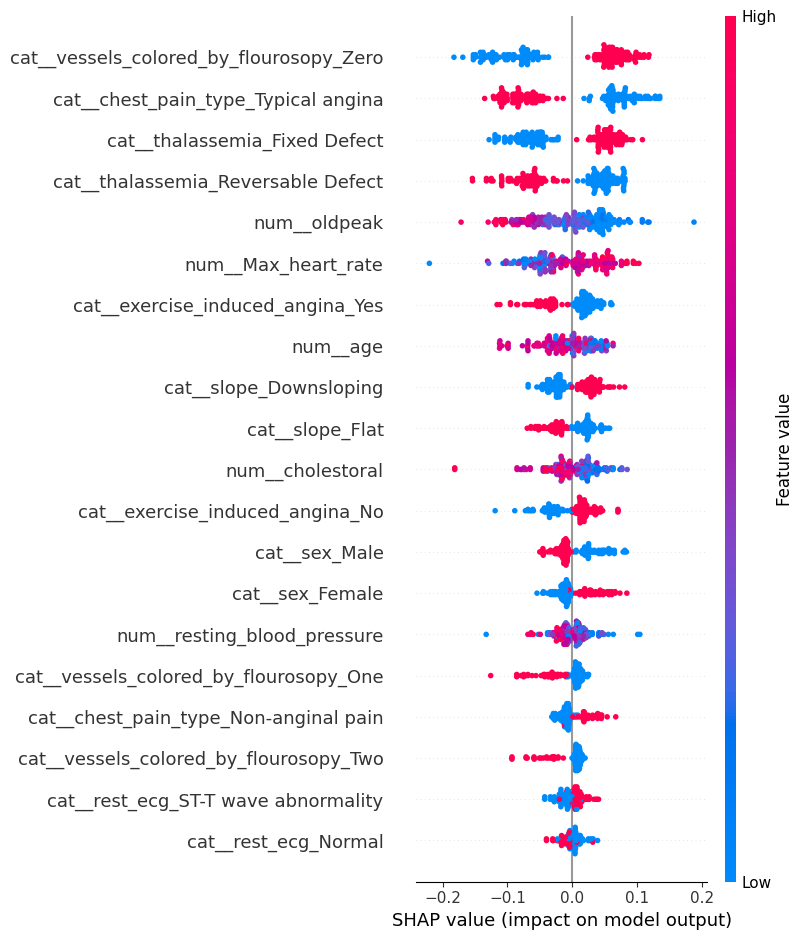

In [92]:
# ------------------------------
# 3. SHAP Global Feature Importance Plot
# ------------------------------

# Global Feature Importance Plot
plt.figure(figsize=(12, 16))
shap.summary_plot(shap_values_for_class_1, X_test_preprocessed, feature_names=feature_names_transformed)


In [93]:
# ------------------------------
# 4. SHAP Local Explanation for a Single Prediction
# ------------------------------

# Local Explanation for a Single Prediction
sample_index = 0

# Select expected value for class 1
expected_value = explainer.expected_value[1]  # Use second expected value (for class 1)

force_plot = shap.plots.force(
    expected_value,
    shap_values_for_class_1[sample_index, :], 
    X_test_preprocessed_df.iloc[sample_index] 
)

# Save and display as an interactive HTML file
shap_html = shap.save_html("shap_output.html", force_plot)
display(HTML("shap_output.html"))


In [94]:
# ------------------------------
# 5. LIME (Local Interpretable Model-Agnostic Explanations)
# ------------------------------

# Step 2: LIME Explanations
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_preprocessed,
    feature_names=feature_names_transformed,  # No need to slice
    class_names=['No Disease', 'Disease'],
    discretize_continuous=True
)

sample_data = X_test_preprocessed_df.iloc[sample_index].values.reshape(1, -1)  
lime_exp = lime_explainer.explain_instance(sample_data[0], rf_clf.predict_proba, num_features=10)

lime_exp.show_in_notebook()


# Model Evaluation and Performance Metrics

In [95]:
# ------------------------------
# 1. Model Evaluation and Performance Metrics
# ------------------------------

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Predictions
y_pred = rf_clf.predict(X_test_preprocessed)
y_pred_proba = rf_clf.predict_proba(X_test_preprocessed)[:, 1]

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9854
ROC AUC Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



### Confusion Matrix of Random Forest

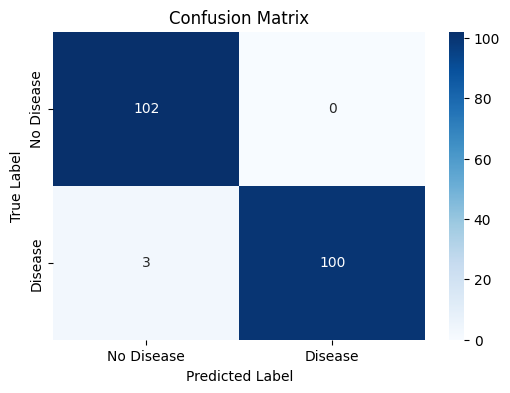

In [96]:
# ------------------------------
# 2. Confusion Matrix
# ------------------------------

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### ROC Curve of Random Forest

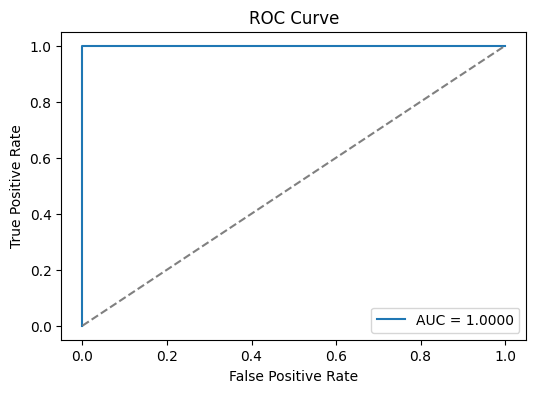

In [97]:
# ------------------------------
# 3. ROC Curve
# ------------------------------

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


### ROC-AUC for All Models

In [98]:
# ------------------------------
# 4. ROC-AUC for All Models
# ------------------------------

from sklearn.metrics import roc_auc_score

# For Logistic Regression, get predicted probabilities
log_reg_pred_proba = log_reg.predict_proba(X_test_preprocessed)[:, 1]
log_reg_roc_auc = roc_auc_score(y_test, log_reg_pred_proba)
print(f"Logistic Regression ROC-AUC Score: {log_reg_roc_auc:.4f}")

# For Decision Tree, get predicted probabilities
dec_tree_pred_proba = dec_tree.predict_proba(X_test_preprocessed)[:, 1]
dec_tree_roc_auc = roc_auc_score(y_test, dec_tree_pred_proba)
print(f"Decision Tree ROC-AUC Score: {dec_tree_roc_auc:.4f}")

# For Random Forest, get predicted probabilities
rf_pred_proba = rf_clf.predict_proba(X_test_preprocessed)[:, 1]
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)
print(f"Random Forest ROC-AUC Score: {rf_roc_auc:.4f}")

# For Gradient Boosting, get predicted probabilities
gb_pred_proba = gb_clf.predict_proba(X_test_preprocessed)[:, 1]
gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)
print(f"Gradient Boosting ROC-AUC Score: {gb_roc_auc:.4f}")

# For Neural Network, get predicted probabilities
nn_pred_proba = nn_model.predict(X_test_preprocessed)
nn_roc_auc = roc_auc_score(y_test, nn_pred_proba)
print(f"Neural Network ROC-AUC Score: {nn_roc_auc:.4f}")


Logistic Regression ROC-AUC Score: 0.9056
Decision Tree ROC-AUC Score: 0.9854
Random Forest ROC-AUC Score: 1.0000
Gradient Boosting ROC-AUC Score: 0.9847
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Neural Network ROC-AUC Score: 0.9930


# Hyperparameter Tuning and Model Finalization

In [99]:
# ------------------------------
# 1. Hyperparameter Tuning Using GridSearchCV
# ------------------------------

from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Apply GridSearchCV for Random Forest Classifier
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_preprocessed, y_train)

# Print the best parameters and the best accuracy score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.9841463414634146


## Evaluate the Best Model (After GridSearchCV) with Cross-Validation

In [100]:
# ------------------------------
# 2. Evaluate the Best Model (After GridSearchCV) with Cross-Validation
# ------------------------------

best_rf_model = grid_search.best_estimator_

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_rf_model, X_train_preprocessed, y_train, cv=5, scoring='accuracy')
print("\nBest Random Forest Model Cross-Validation Scores:")
print(cv_scores)
print(f"Mean Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")



Best Random Forest Model Cross-Validation Scores:
[0.99390244 0.9695122  1.         0.98780488 0.9695122 ]
Mean Accuracy: 0.9841 (+/- 0.0126)


## Final Model Evaluation


Final Random Forest Model Performance (After Hyperparameter Tuning):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



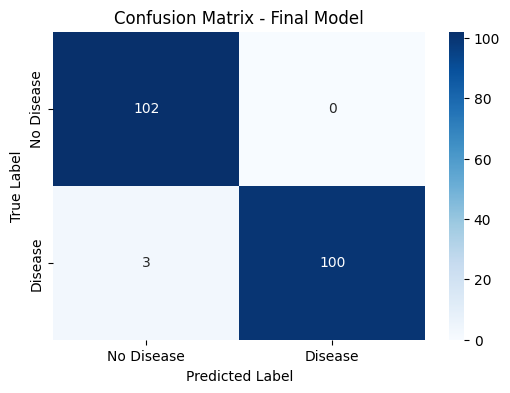

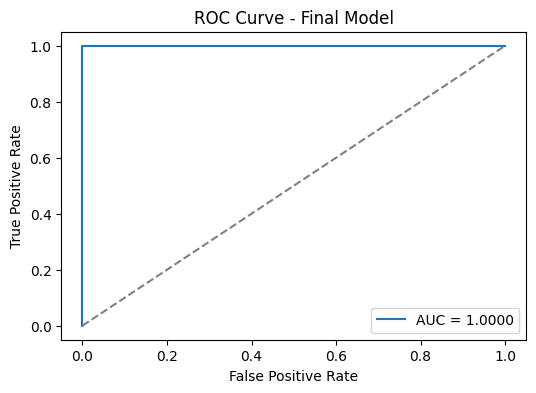

In [101]:
# ------------------------------
# 3. Final Model Evaluation
# ------------------------------

# Predict using the best model
y_pred_best = best_rf_model.predict(X_test_preprocessed)

# Print the classification report for the best model
print("\nFinal Random Forest Model Performance (After Hyperparameter Tuning):")
print(classification_report(y_test, y_pred_best))

# Plot confusion matrix for the final model
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues", xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Final Model")
plt.show()

# Plot ROC curve for the final model
y_pred_proba_best = best_rf_model.predict_proba(X_test_preprocessed)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final Model")
plt.legend()
plt.show()


## Probability Distribution for High-Risk and Low-Risk Patients

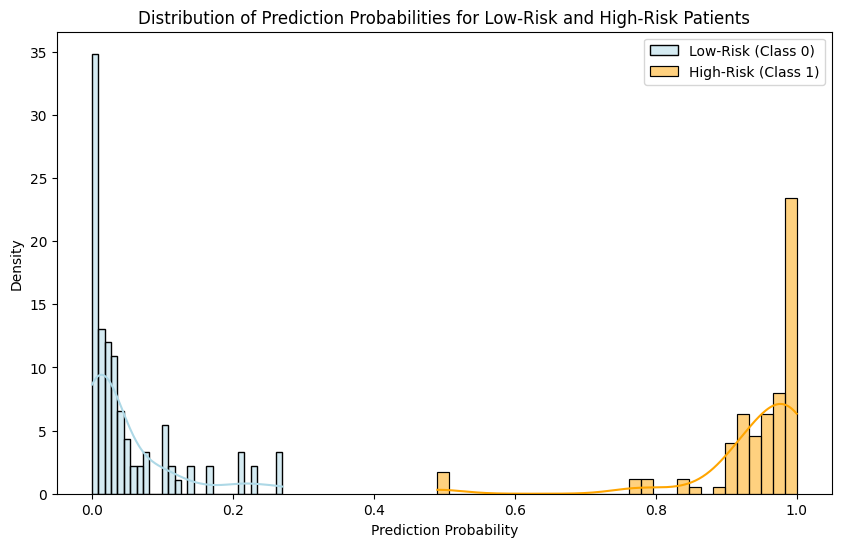

In [102]:
# ------------------------------
# 3. Probability Distribution for High-Risk and Low-Risk Patients
# ------------------------------

# Assuming `rf_clf` is the trained RandomForestClassifier model
# Use the trained model to get prediction probabilities for the test data
y_pred_proba = rf_clf.predict_proba(X_test_preprocessed)[:, 1]  # Get the probability for class 1 (high-risk)

# Create a DataFrame with predicted probabilities and actual target labels
results = pd.DataFrame({'Probability': y_pred_proba, 'Target': y_test})

# Separate the probabilities for class 0 (low-risk) and class 1 (high-risk)
low_risk_prob = results[results['Target'] == 0]['Probability']
high_risk_prob = results[results['Target'] == 1]['Probability']

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(low_risk_prob, color='lightblue', kde=True, label='Low-Risk (Class 0)', stat='density', bins=30)
sns.histplot(high_risk_prob, color='orange', kde=True, label='High-Risk (Class 1)', stat='density', bins=30)

# Add title and labels
plt.title('Distribution of Prediction Probabilities for Low-Risk and High-Risk Patients')
plt.xlabel('Prediction Probability')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


## Scatter Plot/Distribution Plot Showing Predicted Probabilities for Low-Risk Patients

C:\Users\Hammad\AppData\Local\Temp\ipykernel_10828\773364833.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(low_risk_prob, color='lightblue', label='Low-Risk (Class 0)', shade=True)


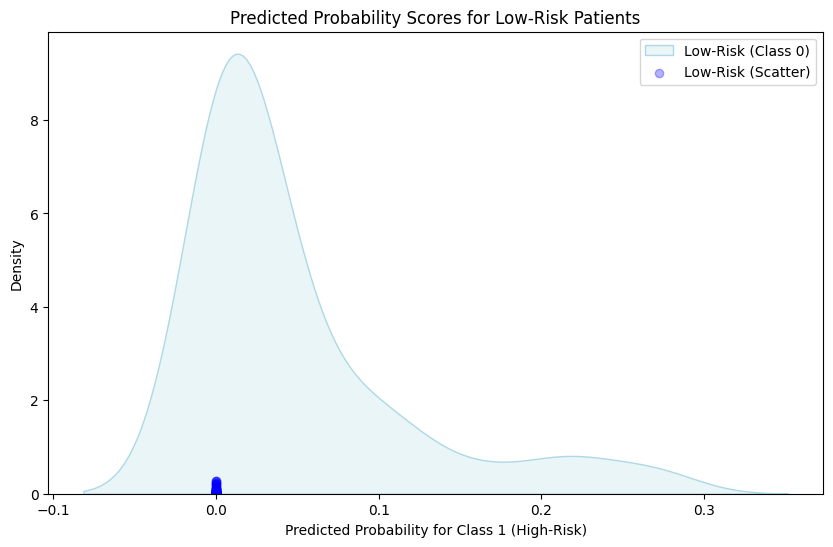

In [103]:
# ------------------------------
# 4. Scatter Plot/Distribution Plot Showing Predicted Probabilities for Low-Risk Patients
# ------------------------------

# Assuming `rf_clf` is the trained RandomForestClassifier model
# Use the trained model to get prediction probabilities for the test data
y_pred_proba = rf_clf.predict_proba(X_test_preprocessed)[:, 1]  # Get the probability for class 1 (high-risk)

# Create a DataFrame with predicted probabilities and actual target labels
results = pd.DataFrame({'Probability': y_pred_proba, 'Target': y_test})

# Separate the probabilities for class 0 (low-risk) and class 1 (high-risk)
low_risk_prob = results[results['Target'] == 0]['Probability']
high_risk_prob = results[results['Target'] == 1]['Probability']

# Plot the distribution of predicted probabilities for low-risk patients (Class 0)
plt.figure(figsize=(10, 6))

# Distribution plot (Kernel Density Estimate) for low-risk patients
sns.kdeplot(low_risk_prob, color='lightblue', label='Low-Risk (Class 0)', shade=True)

# Optionally add a scatter plot for the low-risk patients to show individual predictions
plt.scatter(np.full_like(low_risk_prob, fill_value=0), low_risk_prob, color='blue', alpha=0.3, label='Low-Risk (Scatter)')

# Add title and labels
plt.title('Predicted Probability Scores for Low-Risk Patients')
plt.xlabel('Predicted Probability for Class 1 (High-Risk)')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


## Calibration Curve for Random Forest

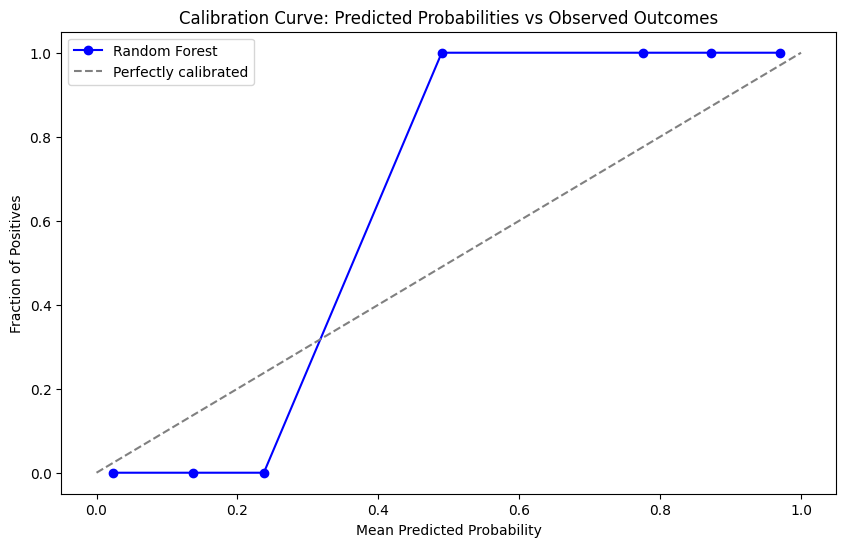

In [104]:
# ------------------------------
# 5. Calibration Curve for Random Forest
# ------------------------------

from sklearn.calibration import calibration_curve

# Assuming `rf_clf` is the trained RandomForestClassifier model
# Use the trained model to get prediction probabilities for the test data
y_pred_proba = rf_clf.predict_proba(X_test_preprocessed)[:, 1]  # Get predicted probabilities for Class 1 (high-risk)

# Get the calibration curve values
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)

# Plotting the calibration curve
plt.figure(figsize=(10, 6))

# Calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Random Forest', color='blue')

# Perfectly calibrated line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Add labels and title
plt.title('Calibration Curve: Predicted Probabilities vs Observed Outcomes')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()

# Show the plot
plt.show()


## Histogram/Bar Plot for High-Risk Predictions

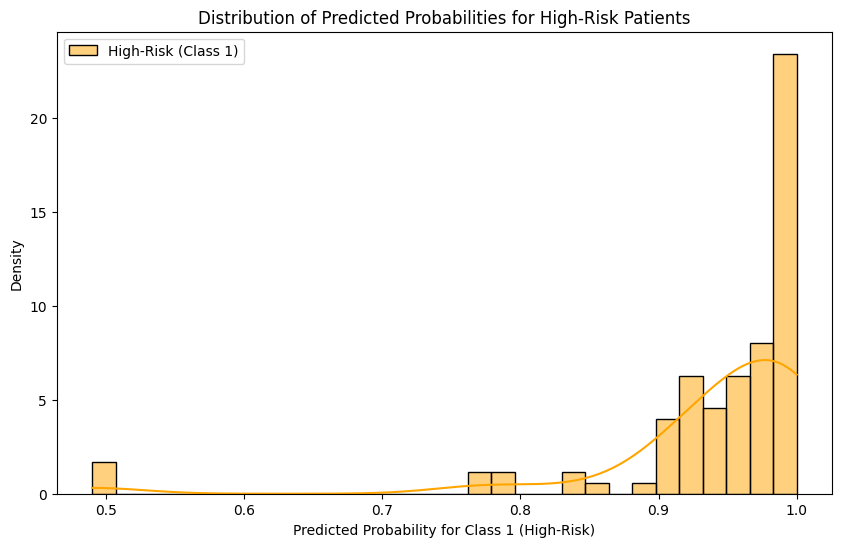

In [105]:
# ------------------------------
# 6. Histogram/Bar Plot for High-Risk Predictions
# ------------------------------

# Assuming `rf_clf` is the trained RandomForestClassifier model
# Use the trained model to get prediction probabilities for the test data
y_pred_proba = rf_clf.predict_proba(X_test_preprocessed)[:, 1]  # Get the predicted probabilities for Class 1 (high-risk)

# Create a DataFrame with predicted probabilities and actual target labels
results = pd.DataFrame({'Probability': y_pred_proba, 'Target': y_test})

# Filter the data to get only high-risk (Class 1) patients
high_risk_prob = results[results['Target'] == 1]['Probability']

# Plot the histogram for high-risk patients
plt.figure(figsize=(10, 6))

# Use seaborn's histplot to visualize the distribution of predicted probabilities for high-risk patients
sns.histplot(high_risk_prob, bins=30, kde=True, color='orange', label='High-Risk (Class 1)', stat='density')

# Add title and labels
plt.title('Distribution of Predicted Probabilities for High-Risk Patients')
plt.xlabel('Predicted Probability for Class 1 (High-Risk)')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()


## Scatter Plot Showing Predicted Probabilities for Low-Risk Patients

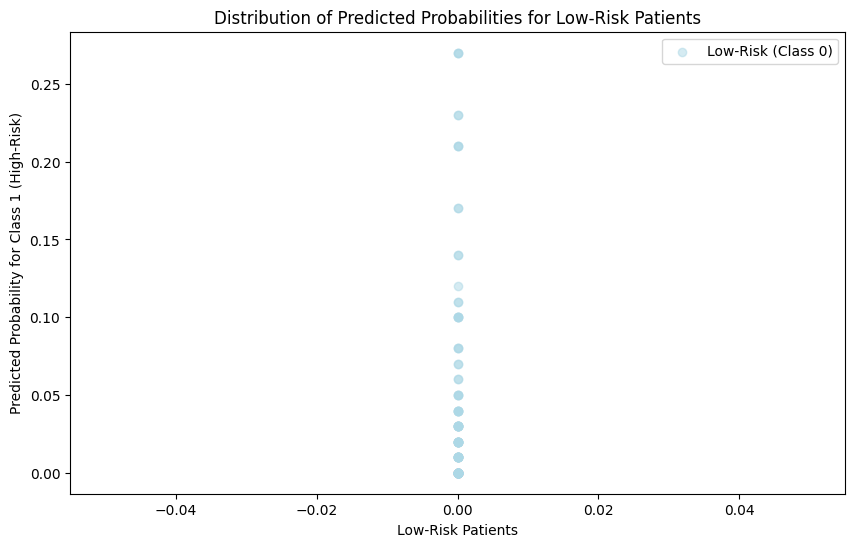

In [106]:
# ------------------------------
# 7. Scatter Plot Showing Predicted Probabilities for Low-Risk Patients
# ------------------------------

# Assuming `rf_clf` is the trained RandomForestClassifier model
# Use the trained model to get prediction probabilities for the test data
y_pred_proba = rf_clf.predict_proba(X_test_preprocessed)[:, 1]  # Get the predicted probabilities for Class 1 (high-risk)

# Create a DataFrame with predicted probabilities and actual target labels
results = pd.DataFrame({'Probability': y_pred_proba, 'Target': y_test})

# Filter the data to get only low-risk (Class 0) patients
low_risk_prob = results[results['Target'] == 0]['Probability']

# Plot the scatter plot for low-risk patients
plt.figure(figsize=(10, 6))

# Scatter plot for low-risk patients (predicted probability for Class 1)
plt.scatter(np.full_like(low_risk_prob, fill_value=0), low_risk_prob, color='lightblue', alpha=0.5, label='Low-Risk (Class 0)')

# Add title and labels
plt.title('Distribution of Predicted Probabilities for Low-Risk Patients')
plt.xlabel('Low-Risk Patients')
plt.ylabel('Predicted Probability for Class 1 (High-Risk)')
plt.legend()

# Show the plot
plt.show()


## Risk Stratification Plot

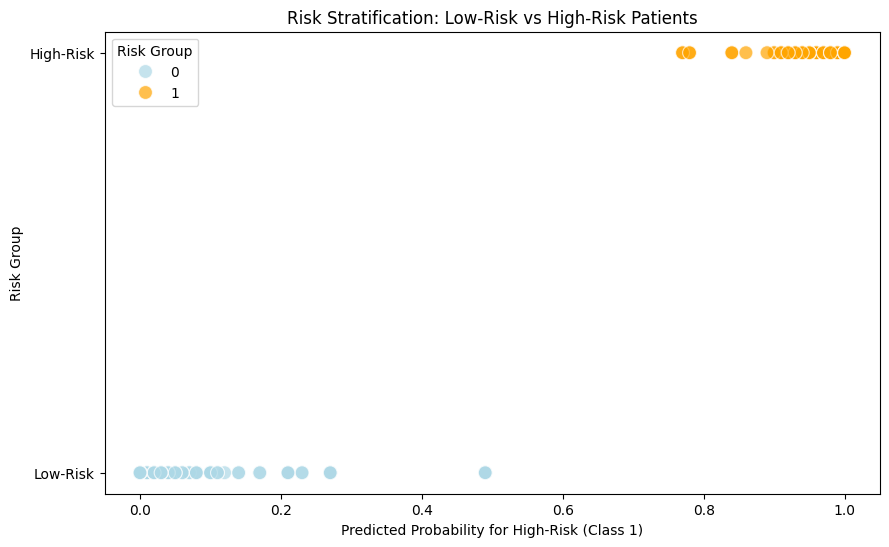

In [107]:
# ------------------------------
# 8. Risk Stratification Plot
# ------------------------------

# Assuming `rf_clf` is the trained RandomForestClassifier model
# Use the trained model to get prediction probabilities for the test data
y_pred_proba = rf_clf.predict_proba(X_test_preprocessed)[:, 1]  # Get the predicted probabilities for Class 1 (high-risk)

# Set a threshold for classification (0.5 in this case)
threshold = 0.5
predicted_risk = (y_pred_proba >= threshold).astype(int)  # 1 for high-risk, 0 for low-risk

# Create a DataFrame with predicted probabilities, actual target labels, and risk classification
results = pd.DataFrame({'Probability': y_pred_proba, 'Target': y_test, 'Risk Group': predicted_risk})

# Plotting the Risk Stratification
plt.figure(figsize=(10, 6))

# Scatter plot: Predicted probabilities vs. Risk Group (Low-Risk vs High-Risk)
sns.scatterplot(data=results, x='Probability', y='Risk Group', hue='Risk Group', palette={0: 'lightblue', 1: 'orange'}, s=100, alpha=0.7)

# Add title and labels
plt.title('Risk Stratification: Low-Risk vs High-Risk Patients')
plt.xlabel('Predicted Probability for High-Risk (Class 1)')
plt.ylabel('Risk Group')
plt.yticks([0, 1], ['Low-Risk', 'High-Risk'])  # Custom y-axis labels
plt.legend(title='Risk Group', loc='upper left')

# Show the plot
plt.show()


# Model Saving, Prediction, and Web App Development

## Save the Trained Model and Preprocessing Pipeline

In [108]:
# ------------------------------
# 1. Save the Trained Model and Preprocessing Pipeline
# ------------------------------

from joblib import dump

# Save the best trained Random Forest model (from GridSearchCV)
dump(grid_search.best_estimator_, "random_forest_model.pkl")
print("✅ Best Model saved as 'random_forest_model.pkl'")

# Save the preprocessor pipeline (used during training)
dump(preprocessor, "preprocessor.pkl")
print("✅ Preprocessor saved as 'preprocessor.pkl'")

# Save test dataset (X_test_preprocessed and y_test)
import numpy as np
np.save("X_test_preprocessed.npy", X_test_preprocessed)
np.save("y_test.npy", y_test)

# Save feature names
np.save("feature_names.npy", np.array(feature_names_transformed, dtype=object))
print("✅ Test data & feature names saved!")


✅ Best Model saved as 'random_forest_model.pkl'
✅ Preprocessor saved as 'preprocessor.pkl'
✅ Test data & feature names saved!


# Heart Disease Prediction Web App Using Streamlit  

***This code is only run in web so there is a separate file named dashboard.py is available. Follow the below steps to run this***  
***Open the Command Prompt (or Terminal)***  
Navigate to the directory where your dashboard.py file is saved like (cd C:\Users\Your Name\Desktop\Project)  
Once you're in the correct directory, run the following command:  
***streamlit run dashboard.py***

In [109]:
# Install the Streamlit package
!pip install streamlit

In [110]:
# ------------------------------
# Heart Disease Prediction Web App Using Streamlit
# ------------------------------

import streamlit as st
import numpy as np
import pandas as pd
import shap
from joblib import load

# Load trained model & preprocessor
rf_clf = load("random_forest_model.pkl")  # Trained Random Forest model
preprocessor = load("preprocessor.pkl")  # Preprocessing pipeline
feature_names_transformed = np.load("feature_names.npy", allow_pickle=True)  # Feature names

# ------------------------------
# User Input Section
# ------------------------------

st.subheader("📝 Enter Patient Data for Prediction")

# Define input fields for user
age = st.number_input("Age", min_value=20, max_value=100, value=50)
sex = st.selectbox("Sex", ["Male", "Female"])
chest_pain = st.selectbox("Chest Pain Type", ["Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"])
rest_bp = st.number_input("Resting Blood Pressure (mm Hg)", min_value=80, max_value=200, value=120)
cholestoral = st.number_input("Cholestoral Level (mg/dL)", min_value=100, max_value=500, value=200)
fasting_bs = st.selectbox("Fasting Blood Sugar > 120 mg/dL", ["No", "Yes"])
rest_ecg = st.selectbox("Resting ECG Results", ["Normal", "ST-T wave abnormality", "Left ventricular hypertrophy"])
max_heart_rate = st.number_input("Maximum Heart Rate Achieved", min_value=60, max_value=220, value=150)
exercise_angina = st.selectbox("Exercise-Induced Angina", ["No", "Yes"])
oldpeak = st.number_input("ST Depression (Oldpeak)", min_value=0.0, max_value=10.0, value=1.0)
slope = st.selectbox("Slope of ST Segment", ["Upsloping", "Flat", "Downsloping"])
num_vessels = st.selectbox("Number of Vessels Colored by Fluoroscopy", ["0", "1", "2", "3"])
thalassemia = st.selectbox("Thalassemia", ["Normal", "Fixed Defect", "Reversible Defect"])

# ------------------------------
# Convert Categorical Inputs
# ------------------------------
sex = 1 if sex == "Male" else 0
chest_pain_mapping = {"Typical Angina": 1, "Atypical Angina": 2, "Non-Anginal Pain": 3, "Asymptomatic": 4}
chest_pain = chest_pain_mapping[chest_pain]
fasting_bs = 1 if fasting_bs == "Yes" else 0
rest_ecg_mapping = {"Normal": 0, "ST-T wave abnormality": 1, "Left ventricular hypertrophy": 2}
rest_ecg = rest_ecg_mapping[rest_ecg]
exercise_angina = 1 if exercise_angina == "Yes" else 0
slope_mapping = {"Upsloping": 1, "Flat": 2, "Downsloping": 3}
slope = slope_mapping[slope]
thal_mapping = {"Normal": 3, "Fixed Defect": 6, "Reversible Defect": 7}
thalassemia = thal_mapping[thalassemia]
num_vessels = int(num_vessels)

# ------------------------------
# Convert to DataFrame with Correct Column Names
# ------------------------------

original_features = [
    "age", "sex", "chest_pain_type", "resting_blood_pressure", "cholestoral",
    "fasting_blood_sugar", "rest_ecg", "Max_heart_rate", "exercise_induced_angina",
    "oldpeak", "slope", "vessels_colored_by_flourosopy", "thalassemia"
]

user_input = np.array([[age, sex, chest_pain, rest_bp, cholestoral, fasting_bs, rest_ecg, max_heart_rate,
                        exercise_angina, oldpeak, slope, num_vessels, thalassemia]])

user_input_df = pd.DataFrame(user_input, columns=original_features)

# ------------------------------
# Apply Preprocessing
# ------------------------------

user_input_transformed = preprocessor.transform(user_input_df)

# Convert transformed output back to DataFrame with transformed feature names
user_input_transformed_df = pd.DataFrame(user_input_transformed, columns=feature_names_transformed)

# ------------------------------
# Prediction Button
# ------------------------------

if st.button("Predict Heart Disease"):
    # Model Prediction
    prediction = rf_clf.predict(user_input_transformed_df)[0]

    # Display Results
    if prediction == 1:
        st.error(f"⚠️ High Risk!")
    else:
        st.success(f"✅ Low Risk!")

2025-03-05 15:28:37.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 15:28:37.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 15:28:37.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 15:28:37.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 15:28:37.934 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 15:28:37.934 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 15:28:37.934 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 15:28:37.942 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

# Interactive Heart Disease Prediction Using Jupyter Widgets

In [111]:
import numpy as np
import pandas as pd
from joblib import load
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import Layout, HTML

# Load trained model & preprocessor
rf_clf = load("random_forest_model.pkl")  # Trained Random Forest model
preprocessor = load("preprocessor.pkl")  # Preprocessing pipeline

# ------------------------------
#  Create Title
# ------------------------------
title = HTML("<h1>📝 Enter Patient Data for Prediction</h1>")
display(title)

# ------------------------------
#  Create Input Widgets
# ------------------------------
style = {'description_width': 'initial'}

# Creating input widgets with adjusted layout (more compact)
age_widget = widgets.IntSlider(
    value=50, min=20, max=100, description="Age:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
sex_widget = widgets.RadioButtons(
    options=["Male", "Female"], description="Sex:", style=style,
    layout=Layout(width="80%", margin="5px")
)
chest_pain_widget = widgets.RadioButtons(
    options=["Typical Angina", "Atypical Angina", "Non-Anginal Pain", "Asymptomatic"],
    description="Chest Pain:", style=style, layout=Layout(width="80%", margin="5px")
)
rest_bp_widget = widgets.IntSlider(
    value=120, min=80, max=200, description="Rest BP:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
cholestoral_widget = widgets.IntSlider(
    value=200, min=100, max=500, description="Cholestoral:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
fasting_bs_widget = widgets.RadioButtons(
    options=["No", "Yes"], description="Fasting Sugar:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
rest_ecg_widget = widgets.RadioButtons(
    options=["Normal", "ST-T wave abnormality", "Left ventricular hypertrophy"], description="Rest ECG:", 
    style=style, layout=Layout(width="80%", margin="5px")
)
max_hr_widget = widgets.IntSlider(
    value=150, min=60, max=220, description="Max HR:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
exercise_angina_widget = widgets.RadioButtons(
    options=["No", "Yes"], description="Exercise Angina:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
oldpeak_widget = widgets.FloatSlider(
    value=1.0, min=0.0, max=10.0, description="Oldpeak:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
slope_widget = widgets.RadioButtons(
    options=["Upsloping", "Flat", "Downsloping"], description="Slope:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
num_vessels_widget = widgets.Dropdown(
    options=["0", "1", "2", "3"], description="Vessels:", style=style, 
    layout=Layout(width="80%", margin="5px")
)
thal_widget = widgets.RadioButtons(
    options=["Normal", "Fixed Defect", "Reversible Defect"], description="Thalassemia:", style=style, 
    layout=Layout(width="80%", margin="5px")
)

# Button to trigger prediction
predict_button = widgets.Button(
    description="Predict Heart Disease", button_style="success", layout=Layout(width="80%", height="40px", margin="20px")
)

# Output area for displaying prediction result
output = widgets.Output(
    layout=Layout(width="80%", border="solid 2px #ccc", padding="10px", margin="20px")
)

# ------------------------------
#  Handle Prediction Logic
# ------------------------------
def predict_on_click(b):
    with output:
        clear_output()
        
        # Get user input
        age = age_widget.value
        sex = 1 if sex_widget.value == "Male" else 0
        chest_pain_mapping = {"Typical Angina": 1, "Atypical Angina": 2, "Non-Anginal Pain": 3, "Asymptomatic": 4}
        chest_pain = chest_pain_mapping[chest_pain_widget.value]
        rest_bp = rest_bp_widget.value
        cholestoral = cholestoral_widget.value
        fasting_bs = 1 if fasting_bs_widget.value == "Yes" else 0
        rest_ecg_mapping = {"Normal": 0, "ST-T wave abnormality": 1, "Left ventricular hypertrophy": 2}
        rest_ecg = rest_ecg_mapping[rest_ecg_widget.value]
        max_heart_rate = max_hr_widget.value
        exercise_angina = 1 if exercise_angina_widget.value == "Yes" else 0
        oldpeak = oldpeak_widget.value
        slope_mapping = {"Upsloping": 1, "Flat": 2, "Downsloping": 3}
        slope = slope_mapping[slope_widget.value]
        num_vessels = int(num_vessels_widget.value)
        thal_mapping = {"Normal": 3, "Fixed Defect": 6, "Reversible Defect": 7}
        thal = thal_mapping[thal_widget.value]

        # Combine user inputs into a single row
        user_input = np.array([[age, sex, chest_pain, rest_bp, cholestoral, fasting_bs, rest_ecg,
                                max_heart_rate, exercise_angina, oldpeak, slope, num_vessels, thal]])
        original_features = [
            "age", "sex", "chest_pain_type", "resting_blood_pressure", "cholestoral",
            "fasting_blood_sugar", "rest_ecg", "Max_heart_rate", "exercise_induced_angina",
            "oldpeak", "slope", "vessels_colored_by_flourosopy", "thalassemia"
        ]
        user_input_df = pd.DataFrame(user_input, columns=original_features)

        # Preprocess input
        user_input_transformed = preprocessor.transform(user_input_df)

        # Make prediction
        prediction = rf_clf.predict(user_input_transformed)[0]

        # Display result (Only Low Risk or High Risk)
        if prediction == 1:
            display(HTML("<h3 style='color:red;'>⚠️ High Risk of Heart Disease!</h3>"))
        else:
            display(HTML("<h3 style='color:green;'>✅ Low Risk of Heart Disease!</h3>"))

# Attach the button click handler
predict_button.on_click(predict_on_click)

# ------------------------------
# Organize Widgets Layout
# ------------------------------
input_widgets = widgets.VBox([
    age_widget, sex_widget, chest_pain_widget, rest_bp_widget, cholestoral_widget, fasting_bs_widget,
    rest_ecg_widget, max_hr_widget, exercise_angina_widget, oldpeak_widget, slope_widget, num_vessels_widget,
    thal_widget
], layout=Layout(width="80%", margin="20px"))

# Create a VBox layout for the button and output
button_and_output = widgets.VBox([predict_button, output], layout=Layout(width="80%", margin="20px"))

# Display the widgets
display(input_widgets, button_and_output)


HTML(value='<h1>📝 Enter Patient Data for Prediction</h1>')